In [1]:
import torch
import gym
import random
from collections import deque, namedtuple
from matplotlib import pyplot as plt
import numpy as np
import os
import time


In [2]:
replayItem = namedtuple('replayItem', ('state', 'action', 'reward', 'next_state', 'done'))
class ReplayMemory:
    def __init__(self, capacity) -> None:
        self.memory = deque(maxlen=capacity)

    def append(self, *args) -> None:
        self.memory.append(replayItem(*args))

    def sample(self, batch_size) -> list:
        return random.sample(self.memory, batch_size)
    
    def __len__(self) -> int:
        return len(self.memory)

import reverb

class ReverbMemory:
    def __init__(self, capacity) -> None:
        self.table_name = 'priority_table'
        self.server = reverb.Server(tables=[
            reverb.Table(
                name=self.table_name,
                sampler=reverb.selectors.Uniform(),
                remover=reverb.selectors.Fifo(),
                max_size=capacity,
                rate_limiter=reverb.rate_limiters.MinSize(1),
            )
        ])
        self.writer_client = reverb.client.Client(f'localhost:{self.server.port}')
        self.reader_client = reverb.client.Client(f'localhost:{self.server.port}')

    def append(self, *args) -> None:
        self.writer_client.insert(replayItem(*args), priorities={self.table_name: 1.0})

    def sample(self, batch_size) -> list:
        samples = self.reader_client.sample(self.table_name, num_samples=batch_size)
        result = [sample[0].data for sample in samples]
        return result

    def __len__(self) -> int:
        return self.writer_client.server_info()['priority_table'].current_size

In [3]:
class DQN(torch.nn.Module):
    def __init__(self, layer_sizes) -> None:
        super().__init__()
        self.layers = torch.nn.Sequential()
        for i in range(len(layer_sizes)-1):
            self.layers.add_module(f'layer{i}', torch.nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            if i < len(layer_sizes)-2:
                self.layers.add_module(f'relu{i}', torch.nn.LeakyReLU())

    def forward(self, x)->torch.Tensor:
        return self.layers(x)

In [4]:
def epsilon_greedy_action(epsilon, action_rewards)->int:
    if random.random() < epsilon:
        return random.randint(0, len(action_rewards)-1)
    else:
        return torch.argmax(action_rewards).item()

In [5]:
def loss_func(policy_model, target_model, states, actions, rewards, next_states, dones, gamma):
    states = torch.tensor(states, dtype=torch.float32)
    next_states = torch.tensor(next_states, dtype=torch.float32)

    actions = torch.from_numpy(np.array(actions, dtype=np.int64)).reshape(-1, 1)
    rewards = torch.from_numpy(np.array(rewards, dtype=np.float32)).reshape(-1, 1)
    dones = torch.from_numpy(np.array(dones, dtype=np.float32)).reshape(-1, 1)
    
    q_values = policy_model.forward(states).gather(1, actions)
    next_q_values = target_model.forward(next_states).max(dim=1, keepdim=True)[0]
    expected_q_values = rewards + gamma * next_q_values * (1 - dones)
    loss = torch.nn.functional.mse_loss(q_values, expected_q_values)
    return loss

In [6]:
def action_remapping(action, biggest):
    # remap from 1 to biggest to -2 to 2
    return (4 * action / (biggest - 1)) - 2

In [7]:
env = gym.make('Pendulum-v1')

tau = 0.01
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.001
epsilon_decay = 0.99
batch_size = 128
memory_size = 1000000
num_episodes = 200
target_update_rate = 4
compiled = True
        
input_shape = env.observation_space.shape
output_shape = 9 #env.action_space.n
hideen_layers = [32, 32, 32]

gradient_clipping_value = 1

model_shape = [*input_shape, *hideen_layers, output_shape]


# memory = ReplayMemory(memory_size)
memory = ReverbMemory(memory_size)
policy_model = DQN(model_shape)
target_model = DQN(model_shape)
target_model.load_state_dict(policy_model.state_dict())
optimizer = torch.optim.Adam(policy_model.parameters(), lr=1e-4)


os.environ["WANDB_NOTEBOOK_NAME"] = "dqn.ipynb"

import wandb

wandb.init(
    project="dqn-pendulum",
    config={
        "type": "Self-Implemented DQN",
        "batch_size": batch_size,
        "buffer_type": "Reverb",
        "compiled": compiled,
    }
)

start_time = time.time()

compile_end_time = time.time()

if compiled:
    policy_model = torch.compile(policy_model)
    target_model = torch.compile(target_model)
    compile_end_time = time.time()

wandb.log({'compile_time': compile_end_time - start_time})

  
episode_steps = []
rewards_tracker = []
for i in range(num_episodes):
    state, _ = env.reset()
    steps = 0
    rewards_tracker.append([])
    while True:
        steps+=1
        qs = policy_model.forward(torch.Tensor(state))
        action = epsilon_greedy_action(epsilon, qs)
        # pendulum remaps actions to [-2, 2]
        real_action = action_remapping(action, output_shape)
        next_observation, reward, done, trunc, info = env.step([real_action])

        memory.append(state, action, reward, next_observation, done)
        state = next_observation
        
        rewards_tracker[-1].append(reward)

        if done or trunc:
            break
        
        if len(memory) > batch_size:
            batch = memory.sample(batch_size)
            states, actions, rewards, next_states, dones = zip(*batch)
            loss = loss_func(policy_model, target_model, states, actions, rewards, next_states, dones, gamma)
            
            policy_model.zero_grad()
            loss.backward()

            # gradient clipping
            # torch.nn.utils.clip_grad_norm_(policy_model.parameters(), gradient_clipping_value)
            optimizer.step()
            
            if steps % target_update_rate == 0:
                target_model.load_state_dict(policy_model.state_dict())
                # soft update
                # for target_param, policy_param in zip(target_model.parameters(), policy_model.parameters()):
                    # target_param.data.copy_(target_param.data * (1.0 - tau) + policy_param.data * tau)
            
    epsilon = max(epsilon_min, epsilon_decay * epsilon)
    episode_steps.append(steps)
    print(f"Episode {i} finished with reward {sum(rewards_tracker[-1])}")
    wandb.log({'reward': sum(rewards_tracker[-1])})        

execution_time_end = time.time()
wandb.log({'execution_time': execution_time_end - start_time})
wandb.finish()

[reverb/cc/platform/tfrecord_checkpointer.cc:162]  Initializing TFRecordCheckpointer in /tmp/tmpak0pdftk.
[reverb/cc/platform/tfrecord_checkpointer.cc:565] Loading latest checkpoint from /tmp/tmpak0pdftk
[reverb/cc/platform/default/server.cc:71] Started replay server on port 43449
wandb: Currently logged in as: unevilicorn (unevilicorn-org). Use `wandb login --relogin` to force relogin


/home/unevilicorn/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (324227) so Table priority_table is accessed directly without gRPC.
/tmp/ipykernel_324227/4231479964.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  states = torch.tensor(states, dtype=torch.float32)
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (324227) so Table priority_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (324227) so Table priority_table is accessed directl

Episode 0 finished with reward -1540.991556374072


[reverb/cc/client.cc:165] Sampler and server are owned by the same process (324227) so Table priority_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (324227) so Table priority_table is accessed directly without gRPC.


Episode 1 finished with reward -757.305140902295
Episode 2 finished with reward -1503.4253100823676


[reverb/cc/client.cc:165] Sampler and server are owned by the same process (324227) so Table priority_table is accessed directly without gRPC.


Episode 3 finished with reward -1710.6506858076896
Episode 4 finished with reward -1307.3105566609465


[reverb/cc/client.cc:165] Sampler and server are owned by the same process (324227) so Table priority_table is accessed directly without gRPC.


Episode 5 finished with reward -1065.2503474138919
Episode 6 finished with reward -1228.9315591360069
Episode 7 finished with reward -1157.5872090565342
Episode 8 finished with reward -1130.1568356131302
Episode 9 finished with reward -870.1842960670433


[reverb/cc/client.cc:165] Sampler and server are owned by the same process (324227) so Table priority_table is accessed directly without gRPC.


Episode 10 finished with reward -961.6278935172963
Episode 11 finished with reward -1428.8597275829754
Episode 12 finished with reward -1169.8683559617107
Episode 13 finished with reward -810.1038795097627
Episode 14 finished with reward -1172.7431404416393
Episode 15 finished with reward -1300.2822336982465
Episode 16 finished with reward -1150.6227885429132
Episode 17 finished with reward -914.4421773588956
Episode 18 finished with reward -1073.2510680312475
Episode 19 finished with reward -1067.0275356100622
Episode 20 finished with reward -1044.628964604329


[reverb/cc/client.cc:165] Sampler and server are owned by the same process (324227) so Table priority_table is accessed directly without gRPC.


Episode 21 finished with reward -856.9787685742943
Episode 22 finished with reward -1035.827413053952
Episode 23 finished with reward -1574.6587073554638
Episode 24 finished with reward -1378.5074430065301
Episode 25 finished with reward -1781.1738868654927
Episode 26 finished with reward -1004.2996675078944
Episode 27 finished with reward -1528.563010337341
Episode 28 finished with reward -1004.9049853456942
Episode 29 finished with reward -1066.9637764046665
Episode 30 finished with reward -1340.6525365114187
Episode 31 finished with reward -1073.6942772541756
Episode 32 finished with reward -1477.1057586351035
Episode 33 finished with reward -1169.1116396696
Episode 34 finished with reward -1190.3232116683362
Episode 35 finished with reward -1065.0395622849078
Episode 36 finished with reward -1091.5416295060977
Episode 37 finished with reward -1080.7281391480708
Episode 38 finished with reward -1265.4233006820668
Episode 39 finished with reward -1153.9665938734022
Episode 40 finishe

[reverb/cc/client.cc:165] Sampler and server are owned by the same process (324227) so Table priority_table is accessed directly without gRPC.


Episode 41 finished with reward -1103.2585250141017
Episode 42 finished with reward -1236.7120381927743
Episode 43 finished with reward -1473.1440280714023
Episode 44 finished with reward -1288.2248830644048
Episode 45 finished with reward -1566.812588553398
Episode 46 finished with reward -1202.158498720023
Episode 47 finished with reward -1218.5953681253093
Episode 48 finished with reward -1040.4603570255904
Episode 49 finished with reward -1697.8390107001892
Episode 50 finished with reward -1595.4571050218278
Episode 51 finished with reward -1179.6255206562978
Episode 52 finished with reward -1376.4698394399438
Episode 53 finished with reward -1230.7413667246406
Episode 54 finished with reward -1356.9640473461789
Episode 55 finished with reward -1156.8628747304026
Episode 56 finished with reward -1383.020088400464
Episode 57 finished with reward -1292.9284238535718
Episode 58 finished with reward -1339.6657735736055
Episode 59 finished with reward -1567.1174670210721
Episode 60 fini

[reverb/cc/client.cc:165] Sampler and server are owned by the same process (324227) so Table priority_table is accessed directly without gRPC.


Episode 82 finished with reward -1347.2167304841873
Episode 83 finished with reward -1061.2680500430408
Episode 84 finished with reward -1486.8102187107431
Episode 85 finished with reward -1168.1092134279872
Episode 86 finished with reward -1168.8994575125507
Episode 87 finished with reward -1320.8843465820923
Episode 88 finished with reward -1199.7036305528231
Episode 89 finished with reward -1402.690685232011
Episode 90 finished with reward -1346.4277934812026
Episode 91 finished with reward -1137.7004075604495
Episode 92 finished with reward -1150.103196333958
Episode 93 finished with reward -1557.8019463419407
Episode 94 finished with reward -1134.2329478240804
Episode 95 finished with reward -1092.0509844120058
Episode 96 finished with reward -1215.2168322349803
Episode 97 finished with reward -1475.2855476150191
Episode 98 finished with reward -1268.7076495285341
Episode 99 finished with reward -1178.9155256970735
Episode 100 finished with reward -1363.944888011616
Episode 101 fi

[reverb/cc/client.cc:165] Sampler and server are owned by the same process (324227) so Table priority_table is accessed directly without gRPC.


Episode 165 finished with reward -1350.0967143292667
Episode 166 finished with reward -1220.2511895116543
Episode 167 finished with reward -1353.9036966890378
Episode 168 finished with reward -1183.4906885313017
Episode 169 finished with reward -1549.6342537406554
Episode 170 finished with reward -1219.4126462556294
Episode 171 finished with reward -1042.1556582829026
Episode 172 finished with reward -1106.6204180030977
Episode 173 finished with reward -1063.47625959584
Episode 174 finished with reward -1236.7388772681024
Episode 175 finished with reward -1278.1450666474798
Episode 176 finished with reward -1054.902415960438
Episode 177 finished with reward -1086.7353047301194
Episode 178 finished with reward -1204.064960065509
Episode 179 finished with reward -1262.9822762254107
Episode 180 finished with reward -1190.382038948331
Episode 181 finished with reward -889.0748425716092
Episode 182 finished with reward -1105.3368770724767
Episode 183 finished with reward -1093.5848150153815

compile_time,▁
execution_time,▁
reward,█▆▃▄▇▁▆▆▆▂▅▅▄▅▅▅▅▄▅▃▆▅▄▆▂▅▆▆▇▆▅▄▅▄▆▆▆▆▅▅
compile_time,0.56229
execution_time,470.0449
reward,-1261.26236


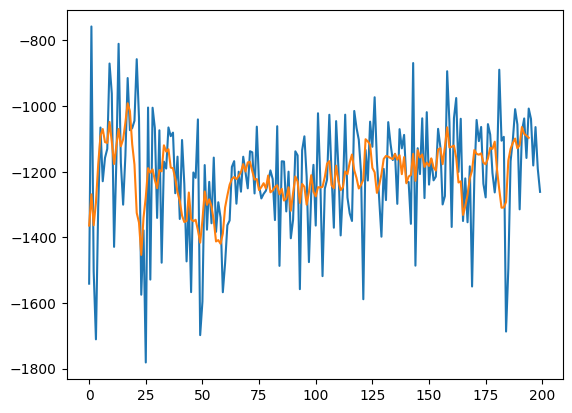

In [8]:
sums = [sum(rewards) for rewards in rewards_tracker]
plt.plot(sums)
window = 5
plt.plot([sum(sums[i:i+window])/window for i in range(len(sums)-window)])
plt.show()

In [9]:
# plt.plot(episode_steps)